In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

In [221]:
# A function that gives a visual representation of the decision tree
def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    # Export our decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    
    # Call graphviz to make an image file from our decision tree
    os.system("dot -Tpng images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')

# A function to plot the data
def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 0 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) - 1, max(data[v1]) + 1])
    plt.ylim([min(data[v2]) - .05, max(data[v2]) + .05])
    
def Decision_Surface(x, y, model, cell_size=.01):
    # Get blob sizes for shading
    initial_x = x
    initial_y = y
    x = (min(x), max(x))
    y = (min(y), max(y))
    x_step = (x[1] - x[0]) * cell_size
    y_step = (y[1] - y[0]) * cell_size

    # Create blobs
    x_values = []
    y_values = []
    
    for i in np.arange(x[0], x[1], x_step):
        for j in np.arange(y[0], y[1], y_step):
            y_values.append(float(i))
            x_values.append(float(j))
    
    data_blob = pd.DataFrame({"x": x_values, "y": y_values})

    # Predict the blob labels
    label= decision_tree.predict(data_blob)
    
    # Color and plot them
    color = ["red" if l == 0 else "blue" for l in label]
    plt.scatter(data_blob['y'], data_blob['x'], marker='o', edgecolor='black', linewidth='0', c=color, alpha=0.3)
    
    # Get the raw decision tree rules
    decision_tree_raw = []
    for feature, left_c, right_c, threshold, value in zip(decision_tree.tree_.feature, 
                                                          decision_tree.tree_.children_left, 
                                                          decision_tree.tree_.children_right, 
                                                          decision_tree.tree_.threshold, 
                                                          decision_tree.tree_.value):
        decision_tree_raw.append([feature, left_c, right_c, threshold, value])

    # Plot the data
    # Modified from original function to be used for any pair of feature inputs
    Plot_Data(data, initial_x.name, initial_y.name, "mpg_num")

    # Used for formatting the boundry lines
    currentAxis = plt.gca()
    line_color = "black"
    line_width = 3

    # For each rule
    for row in decision_tree_raw:
        feature, left_c, right_c, threshold, value = row

        if threshold != -2:
            if feature == 0:
                plt.plot([20, 100], [threshold, threshold], c=line_color, linewidth=line_width)
            else:
                plt.plot([threshold, threshold], [0, 5], c=line_color, linewidth=line_width)

    plt.xlim([min(x) - 1, max(x) + 1])
    plt.ylim([min(y) - .05, max(y) + .05])
    plt.show()

In [22]:
def entropy(target):
    # Get the number of users
    n = len(target)
    # Count how frequently each unique value occurs
    counts = np.bincount(target).astype(float)
    # Initialize entropy
    entropy = 0
    # If the split is perfect, return 0
    if len(counts) <= 1 or 0 in counts:
        return entropy
    # Otherwise, for each possible value, update entropy
    for count in counts:
        entropy += math.log(count/n, len(counts)) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

In [130]:
with open("mpg.csv") as datafile:
    data = pd.read_csv(datafile)
mpg_num = []
for x in data["mpg"]:
    if x == "Good" or x == "OK":
        mpg_num.append(1)
    else:
        mpg_num.append(0)
data["mpg_num"] = mpg_num
for i in range(0, len(data)):
    if data["maker"][i] == "Asia":
        data.set_value(i, 'maker', 0)
    if data["maker"][i] == "America":
        data.set_value(i, 'maker', 1)
    if data["maker"][i] == "Europe":
        data.set_value(i, 'maker', 2)
X = data[["cylinders", "displacement", "horsepower", "weight", "acceleration", "modelyear", "maker"]]
Y = data["mpg_num"]
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,maker,mpg_num
0,Bad,8,350,150,4699,14.5,74,1,0
1,Bad,8,400,170,4746,12.0,71,1,0
2,Bad,8,400,175,4385,12.0,72,1,0
3,Bad,6,250,72,3158,19.5,75,1,0
4,Bad,8,304,150,3892,12.5,72,1,0
5,Bad,8,350,145,4440,14.0,75,1,0
6,Bad,6,250,105,3897,18.5,75,1,0
7,Bad,6,163,133,3410,15.8,78,0,0
8,Bad,8,260,110,4060,19.0,77,1,0
9,Bad,8,305,130,3840,15.4,79,1,0


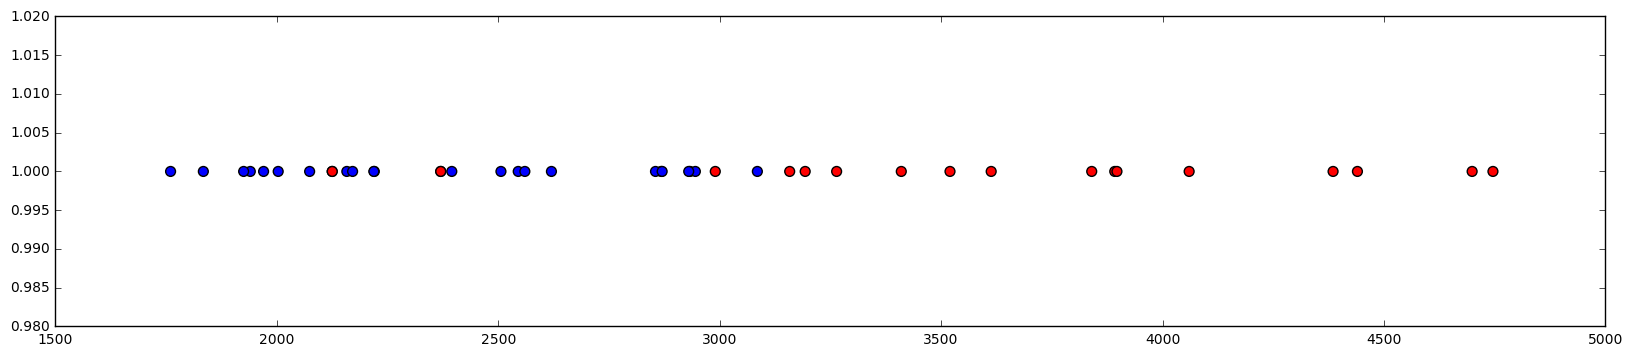

In [224]:
X = data[["cylinders", "displacement", "horsepower", "weight", "acceleration", "modelyear", "maker"]]
Y = data["mpg_num"]
plt.rcParams['figure.figsize'] = [20.0, 4.0]
color = ["red" if x == 0 else "blue" for x in data["mpg_num"]]
plt.scatter(X['weight'], [1] * len(Y), c=color, s=50)

In [109]:
def best_threshold(feature, X, Y):
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X[feature]:
        ig = information_gain(X[feature], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG of %s = %.3f and it occured by splitting on %.4f." % (feature, maximum_ig, maximum_threshold)

for x in X:
    print best_threshold(x, X, Y)

The maximum IG of cylinders = 0.404 and it occured by splitting on 6.0000.
The maximum IG of displacement = 0.482 and it occured by splitting on 163.0000.
The maximum IG of horsepower = 0.370 and it occured by splitting on 105.0000.
The maximum IG of weight = 0.542 and it occured by splitting on 3158.0000.
The maximum IG of acceleration = 0.087 and it occured by splitting on 13.0000.
The maximum IG of modelyear = 0.062 and it occured by splitting on 80.0000.
The maximum IG of maker = 0.192 and it occured by splitting on 2.0000.


From above, we can see that the top 3 most informative features are weight, displacement, and cylinders.

The maximum IG of weight = 0.542 and it occured by splitting on 3158.0000.  
The maximum IG of displacement = 0.482 and it occured by splitting on 163.0000.  
The maximum IG of cylinders = 0.404 and it occured by splitting on 6.0000.

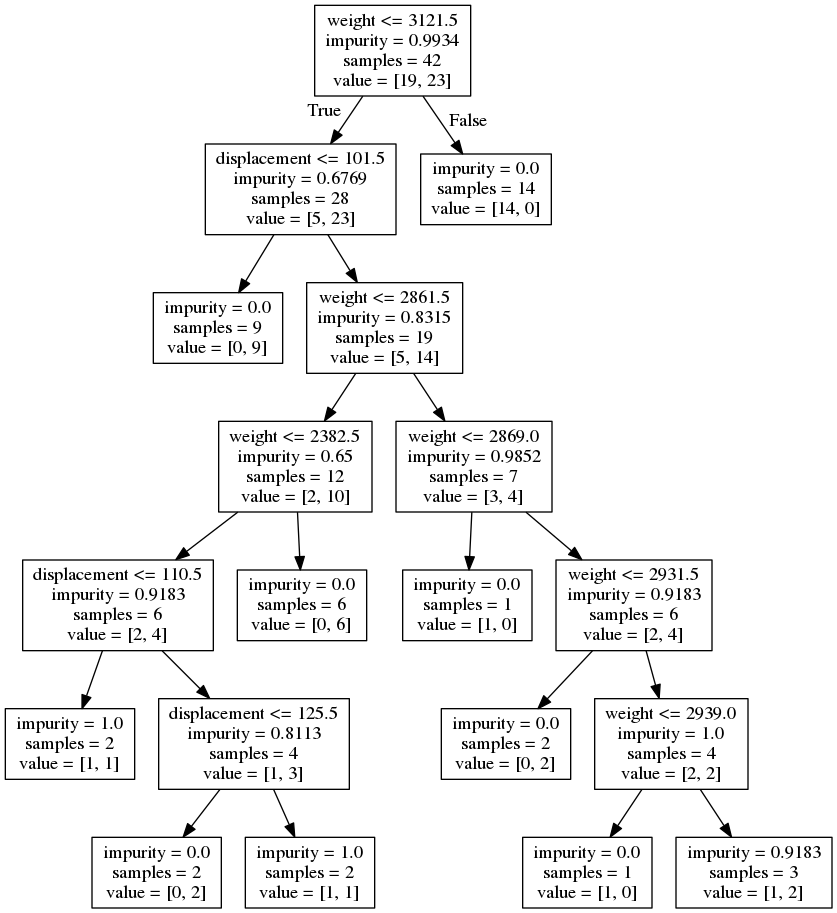

In [225]:
X1 = data[["displacement", "weight"]]
decision_tree = DecisionTreeClassifier(max_depth=6, criterion="entropy")
decision_tree.fit(X1, Y)
Decision_Tree_Image(decision_tree, X1.columns)

In [226]:
print "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(X1), Y))

Accuracy = 0.929


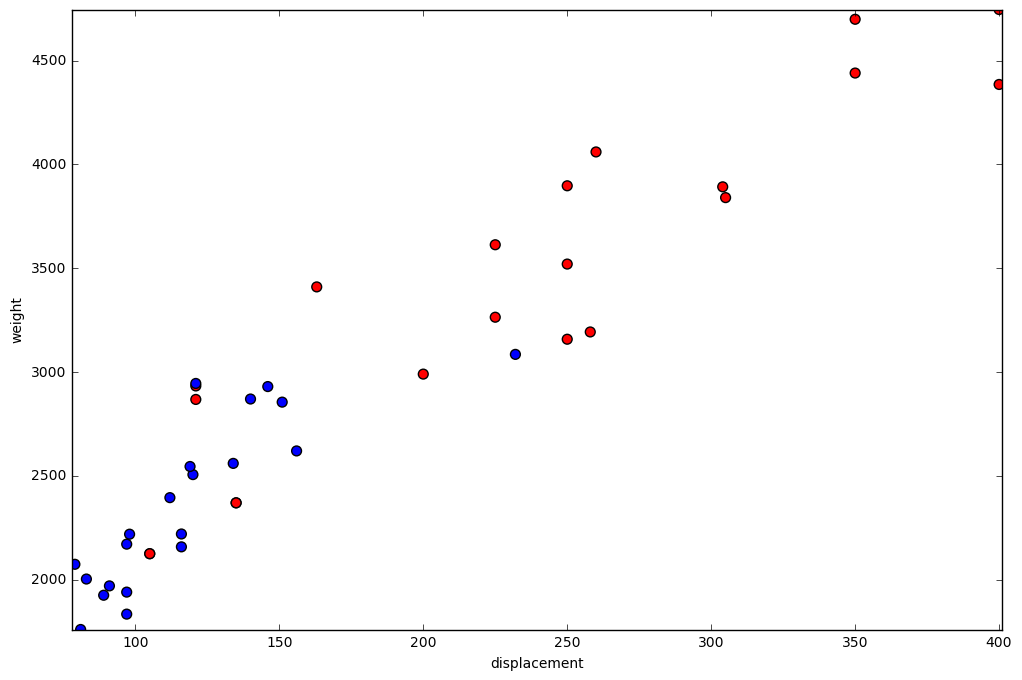

In [193]:
Plot_Data(data, "displacement", "weight", "mpg_num")

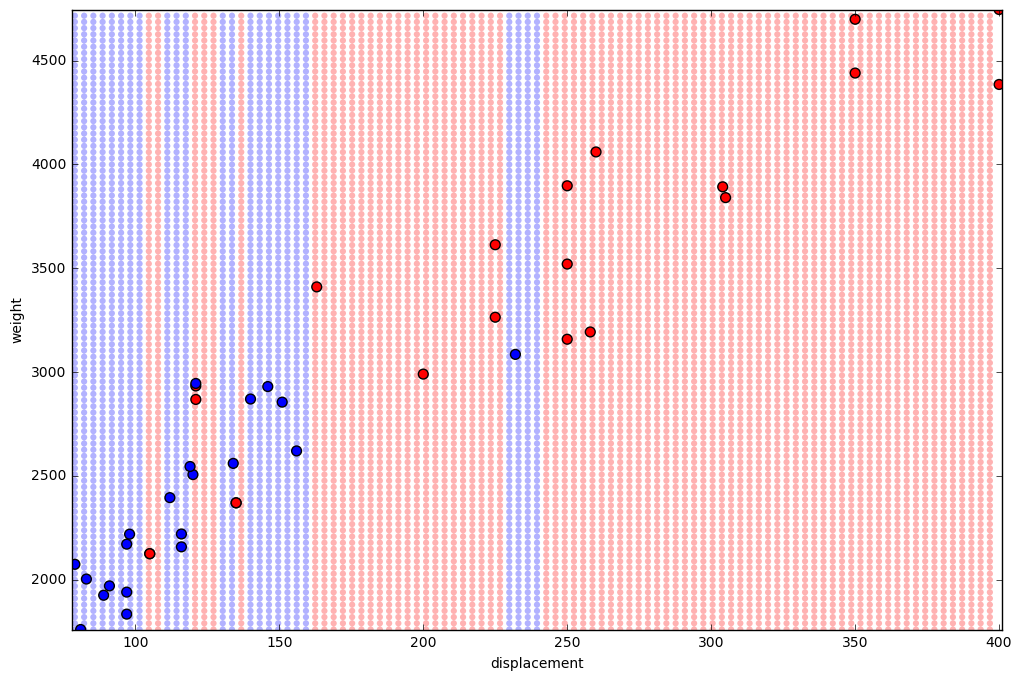

In [222]:
Decision_Surface(data['displacement'], data['weight'], decision_tree)

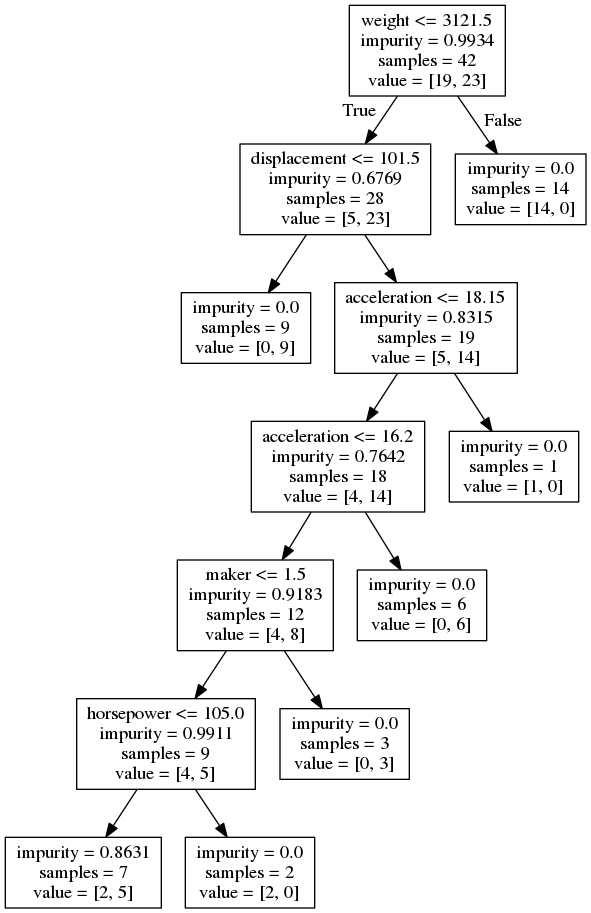

In [210]:
X2 = data[["cylinders", "displacement", "horsepower", "weight", "acceleration", "modelyear", "maker"]]
decision_tree2 = DecisionTreeClassifier(max_depth=6, criterion="entropy")
decision_tree2.fit(X2, Y)
Decision_Tree_Image(decision_tree2, X2.columns)

In [211]:
print "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree2.predict(X2), Y))

Accuracy = 0.952


Conclusion:  
The highest accuracy I can get is 0.952, using all 7 features and depth of 6. If I increase the depth to a value > 6, the accuracy doesn't improve any further, but if i reduce the depth to 5, the accuracy drops to 0.905. However, if I use just 2 features (weight and displacement) for the decision tree, I can still get to a fairly high accuracy of 0.929, which is definitely a model that is less over-fitted to this dataset, but not required in the context of this homework.